In [1]:
import os
import cv2 
import numpy as np
from PIL import Image
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout,Conv2D,Activation,BatchNormalization,MaxPooling2D
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
train_dir='New_Rice_Dataset/train'
validation_dir='New_Rice_Dataset/validation'
train_dataset=tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=64,
    image_size=(32, 32),
    shuffle=True,
    validation_split=0.2,
    subset='training',
    seed=0,
    interpolation="bilinear"
)
val_dataset=tf.keras.preprocessing.image_dataset_from_directory(
    validation_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=64,
    image_size=(32, 32),
    shuffle=True,
    validation_split=0.2,
    subset='validation',
    seed=0,
    interpolation="bilinear"
)

Found 1200 files belonging to 3 classes.
Using 960 files for training.
Found 150 files belonging to 3 classes.
Using 30 files for validation.


In [3]:
from tensorflow.keras import layers
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), tf.cast(y, dtype=tf.int32)))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), tf.cast(y, dtype=tf.int32)))

In [4]:
l2 = tf.keras.regularizers.l2(0.01)
params = {'activation': 'relu',
      'optimizer': 'Adam',
      'losses': 'categorical_crossentropy',
      'batch_size': 1500,
      'epochs': 60,
      'node_1' : 384,
      'node_2' : 256,
      'regularizers' :l2,
      'input_shape' :(32,32,3),
      'output_shape' : 3
    }
def create_model(params):
      net = VGG16(include_top=False, weights='imagenet', input_tensor=None,
              input_shape = (params['input_shape'])
              )
      
      # 透過layer_name 節取 model的某一層 block3_pool 
      layer_name='block3_pool'

      # 設定取到該層的都使用預設參數，不訓練參數
      layer_index=net.layers.index(net.get_layer(layer_name))
      
      # 建立模型
      base_model = net.get_layer(layer_name).output
  # base_model = tf.keras.layers.Conv2D(128, (1, 1), padding='valid')(base_model)
  # base_model = tf.keras.layers.MaxPooling2D( pool_size = (3, 3) )(base_model)
      # 攤平 feature map 
      base_model = Flatten()(base_model)

      base_model = Dropout(0.3)(base_model)
      base_model = tf.keras.layers.BatchNormalization()(base_model)
      base_model = Dense(units = params['node_1'], kernel_initializer = tf.keras.initializers.GlorotNormal()
                 ,kernel_regularizer= params['regularizers'] , activation= params['activation'])(base_model)


      base_model = Dense(units = params['node_2'], kernel_initializer = tf.keras.initializers.GlorotNormal()
                 ,kernel_regularizer = params['regularizers'] , activation= params['activation'])(base_model)

      base_model = Dropout(0.3)(base_model)
      output_layer = Dense(params['output_shape'], activation='softmax', name='softmax')(base_model)

      # 設定凍結與要進行訓練的網路層
      net_final = Model(inputs=net.input, outputs=output_layer)
      for layer in net_final.layers[:layer_index]:
          layer.trainable = False

      return net_final

In [5]:
# with strategy.scope():
model = create_model(params)
precision=tf.keras.metrics.Precision(name='precision')
recall=tf.keras.metrics.Recall(name='recall')
accuracy=tf.keras.metrics.CategoricalAccuracy(name='accuracy')
model.compile(optimizer=params['optimizer'],
        loss=params['losses'],
        metrics = [recall,precision,accuracy],
        
        )
print(model.summary())
callbacks_list=[
  tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',mode='min', patience=20 ,restore_best_weights=True),
  tf.keras.callbacks.ModelCheckpoint(
            filepath='./C10_VGG16_01',
            monitor='val_loss',
            save_best_only=True),
  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                        patience=5,                      
                        verbose=1,
                        factor=0.3,  
                        min_lr=0.00001 )  
        ]
out = model.fit(
          train_dataset,
          validation_data=val_dataset,
          epochs=10,
          callbacks=callbacks_list               
            )

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [33]:
from tensorflow.keras import layers
test_dir='New_Rice_Dataset/test'
test_dataset=tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=64,
    image_size=(32, 32),
    shuffle=True,
    interpolation="bilinear"
)
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), tf.cast(y, dtype=tf.int32)))

Found 150 files belonging to 3 classes.


In [34]:
vgg1=tf.keras.models.load_model('./C10_VGG16_01')

In [39]:
preds=vgg1.evaluate(test_dataset)

3/3 [==============================] - 1s 56ms/step - loss: 2.1467 - recall: 0.8867 - precision: 0.8986 - accuracy: 0.8933


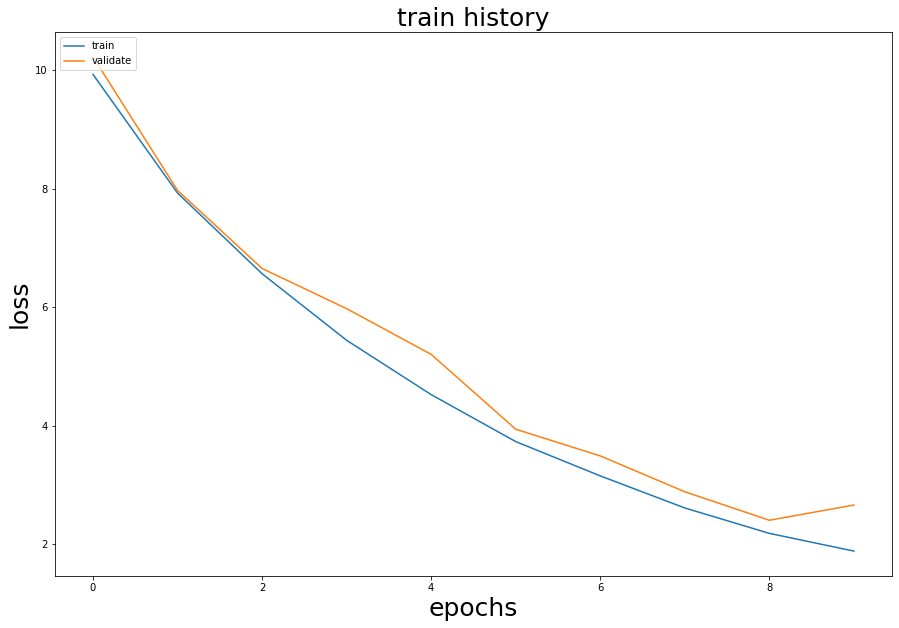

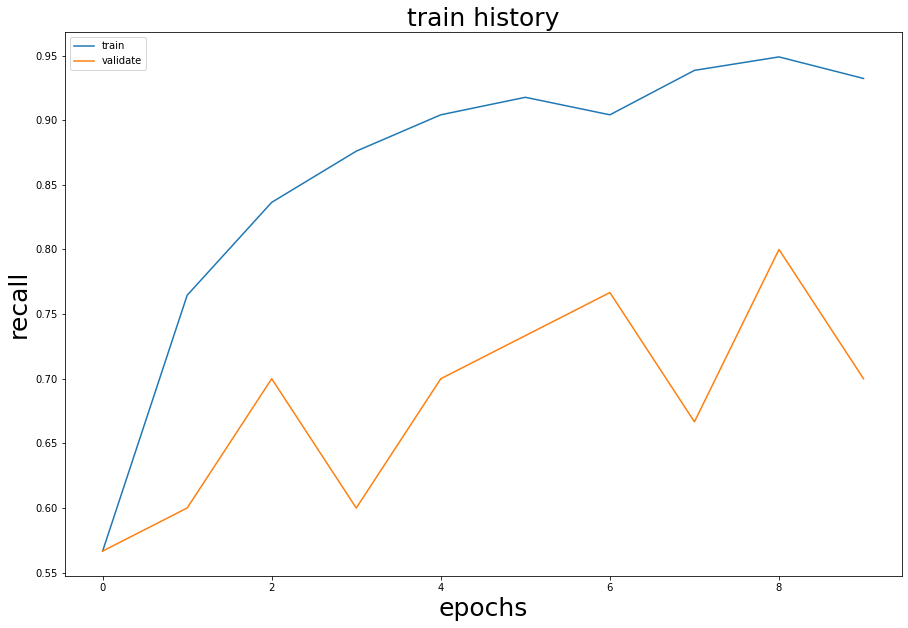

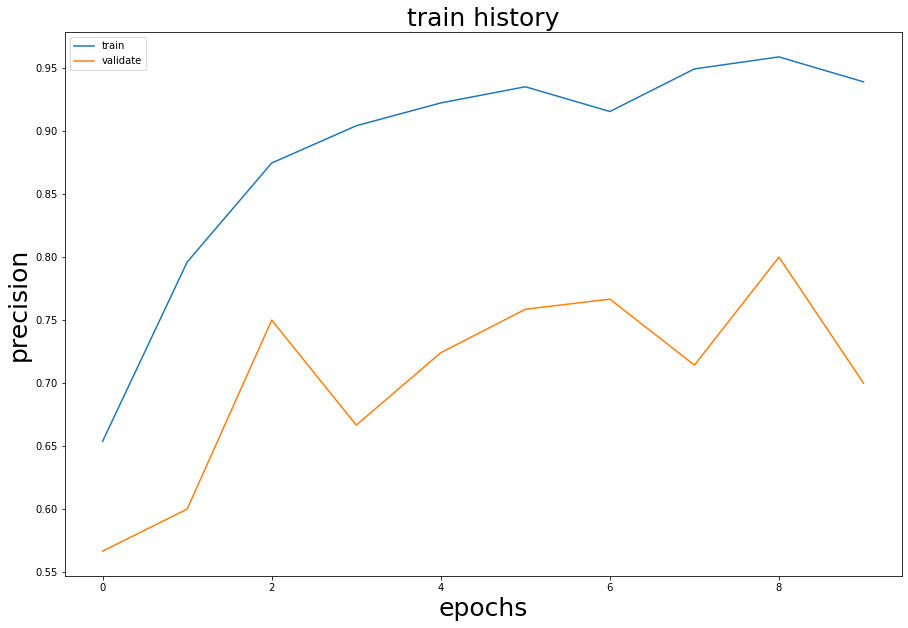

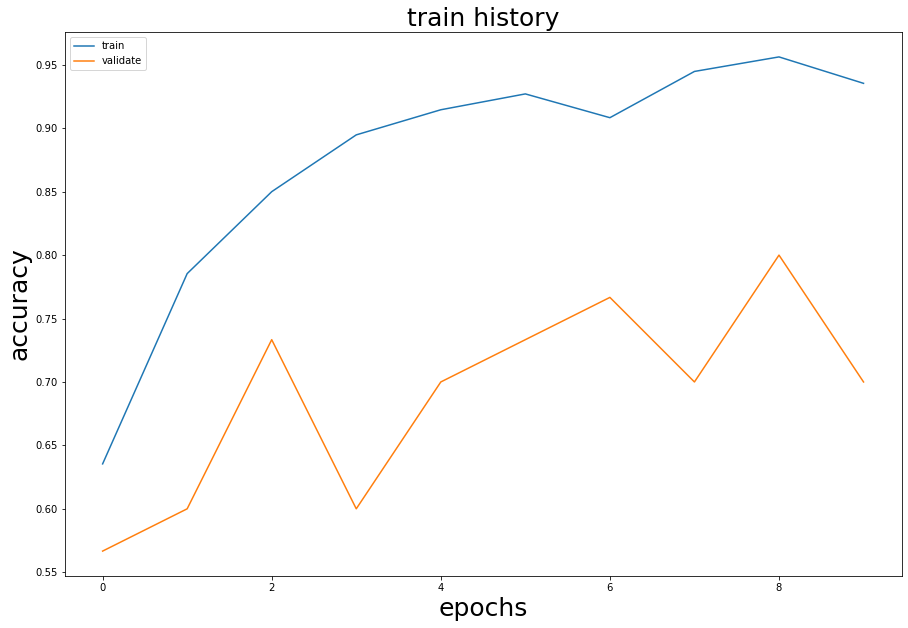

In [56]:
import matplotlib.pyplot as plot  # plot 可以視為畫布

def train_history_graphic( history       # 資料集合
                         , history_key1  # 資料集合裡面的來源 1 (有 loss, acc, val_loss, val_acc 四種)
                         , history_key2  # 資料集合裡面的來源 2 (有 loss, acc, val_loss, val_acc 四種)
                         , y_label       # Y 軸標籤文字
                         , index=0
                         ) :
    plot.figure(figsize=(15,10))
    font_size=25
    # 資料來源 1
    plot.plot( out.history[history_key1][index:] )
    # 資料來源 2
    plot.plot( out.history[history_key2][index:] )
    # 標題
    plot.title( 'train history',fontsize=font_size )
    # X 軸標籤文字
    plot.xlabel( 'epochs',fontsize=font_size )
    # Y 軸標籤文字
    plot.ylabel( y_label,fontsize=font_size )
    # 設定圖例
    # (參數 1 為圖例說明, 有幾個資料來源, 就對應幾個圖例說明)
    # (參數 2 為圖例位置, upper 為上面, lower 為下面, left 為左邊, right 為右邊)
    plot.legend( ['train', 'validate']
               , loc = 'upper left'
               )
    # 顯示畫布
    plot.show()
# 

#############################################
metrics_list=['loss','recall','precision','accuracy']
for metrics in metrics_list :
  train_history_graphic( vgg1, metrics, f'val_{metrics}', metrics, 0 )

In [59]:
def evaluate_model_1(model,test_dataset):
  precision=tf.keras.metrics.Precision(name='precision')
  recall=tf.keras.metrics.Recall(name='recall')
  accuracy=tf.keras.metrics.CategoricalAccuracy(name='accuracy')
  model.compile(optimizer='Adam',
        loss='categorical_crossentropy',
        metrics = [precision,recall,accuracy]
              )
  preds=model.evaluate(test_dataset)
  print(model)
  print('loss ： %.5f' % preds[0])
  print('precision：%.5f' % preds[1])
  print('recall：%.5f' % preds[2])
  print('accuracy： %.5f' %preds[3])
  F1 = 2 * (preds[1] * preds[2]) / (preds[1] + preds[2])
  print('f1score：%.5f' % F1)
  print("===========================================")
  preds.append(F1)
  return pd.DataFrame([preds],columns=['loss','precision','recall','accuracy','f1score'])

# model out 
df=evaluate_model_1(vgg1,test_dataset)
df

3/3 [==============================] - 2s 60ms/step - loss: 2.1467 - precision: 0.8986 - recall: 0.8867 - accuracy: 0.8933
loss ： 2.14666
precision：0.89865
recall：0.88667
accuracy： 0.89333
f1score：0.89262


,loss,precision,recall,accuracy,f1score
0,2.146662,0.898649,0.886667,0.893333,0.892617
